<b><font size="40">May A.I. sa Basura: Garbage Classification Using Convolutional Neural Networks</font></b>

Jeffrey L. Go, Ma. Angela Legaspi, Accever Mendoza, and Van Arloe M. Yu

Aboitiz School of Innovation, Technology, and Entrepreneurship
Asian Institute of Management Paseo de Roxas, Makati City

*Corresponding author: jlgo@aim.edu, mlegaspi@aim.edu, amendoza@aim.edu, vayu@aim.edu 


# Abstract

In the Philippines, tons of garbage is generated every single day and are steadily increasing every year. The paper aims to use artificial intelligence to create a model to classify different types of garbage using convolutional neural network. The data from Kaggle contains metal, paper, cardboard, trash, glass, and plastic. The authors added sachet because it is one of the most common types of garbage in the Philippines. The baseline to beat is 21% which is 1.25 x PCC and also 77% from the submission in Kaggle. The Xception model, a pretrained Convolutional Neural Network (CNN), was used as a base for the classifier model. The resulting accuracy was 83% which outperformed the baseline. This can help automate waste segregation facilities in the country. The results could further be improved by adding more data for each class and be more representative by adding more classes of wastes.

Keywords: Waste Segregation, Xception, Transfer Learning, Convolutional Neural Network, Machine Learning, Deep Learning, Artificial Intelligence


# Introduction

The Philippines generates an estimated 43,684 tons of garbage daily, including 4,609 tons of plastic waste (Romulo, 2019). Currently, Metro Manila alone generates 12,500 tons of waste which put the city among the top five most severe waste-ridden cities in the world (Masigan, 2019). This is brought about by the increase in population, enhanced standard of living and development of both the urban and rural areas. The projected solid waste production is expected to be 77,776 tons throughout the country by 2025 (SEPO, 2017). There are many programs implemented both in the local and national to properly manage wastes, but what the country needs is a sustainable solution. This paper aims to use artificial intelligence (AI) to develop a model for garbage classification using convolutional neural networks. This research aims to include the Philippine context to address the generated 164 million sachet waste daily (Cabico, 2019).

# Data and Methodology

In [41]:
import glob
import re
import os

import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPool3D
from tensorflow.keras.layers import Dropout, Input, BatchNormalization

from tensorflow.keras.applications.xception import Xception

from tensorflow.keras import backend

from tensorflow.keras.callbacks import ModelCheckpoint


## Data

Data was obtained from a student in Wuhan University and was extracted from Kaggle (Garbage Classification, 2018).  To augment the data and make it relevant here in the Philippines, we add one of the more common types of garbage: sachet. Different types of sachet were acquired, and their images are taken.

The garbage image dataset is structured such that images in separate classes are in different folders. We add sachets under a new folder. Data are stored in Jojie under the folder `jlgo/ml2_project/`. We start by scanning the directory structure of our data.


In [52]:
folders = glob.glob('garbage classification/Garbage classification/*/', recursive=True)
folders

['garbage classification/Garbage classification/metal/',
 'garbage classification/Garbage classification/paper/',
 'garbage classification/Garbage classification/sachet/',
 'garbage classification/Garbage classification/cardboard/',
 'garbage classification/Garbage classification/trash/',
 'garbage classification/Garbage classification/glass/',
 'garbage classification/Garbage classification/plastic/']

We have a total of seven classes, namely metal, paper, sachet, cardboard, trash, glass and plastic. Paper has the most images with 594, and sachets have the least with 103.

In [53]:
garbages = []
garbage_count = []
sample_image_dir = []

for folder in folders:
    garbage_type = re.search(r'garbage classification/Garbage classification/(.*)/', folder).group(1)
    img_data = glob.glob(folder + '*.jpg')
    sample_image_dir.append(img_data[0])
    
    garbages.append(garbage_type)
    garbage_count.append(len(img_data))


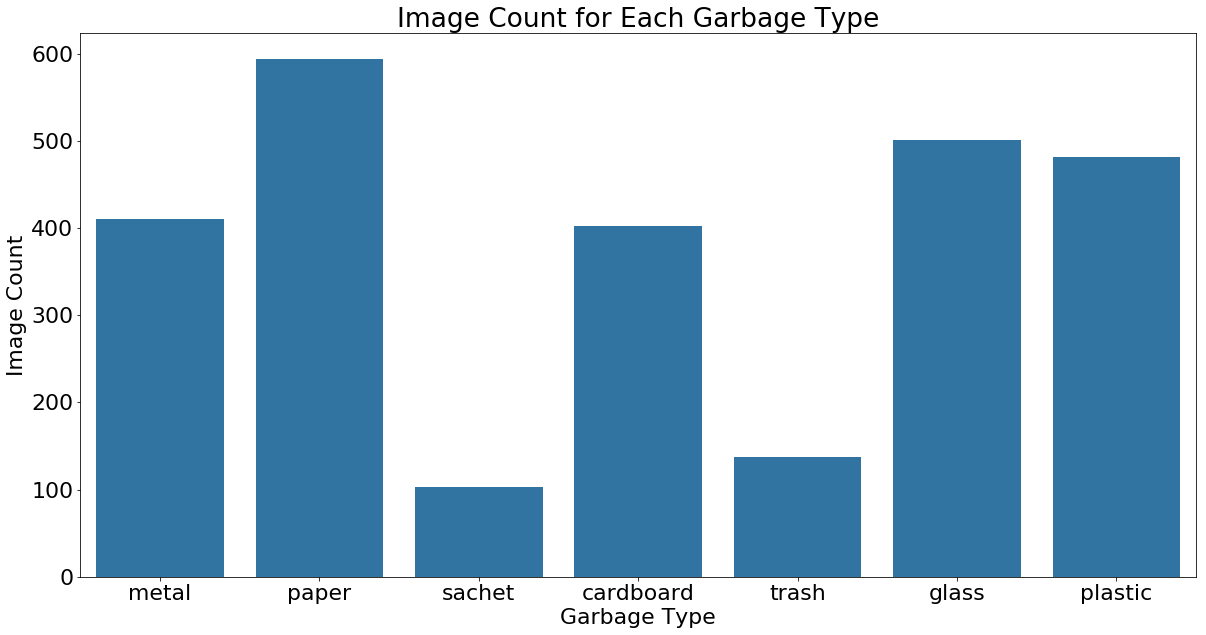

In [29]:
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=garbages, y=garbage_count, color='C0', ax=ax)

ax.set_title('Image Count for Each Garbage Type')
ax.set_xlabel('Garbage Type')
ax.set_ylabel('Image Count');

Below, we show some example images for each class.

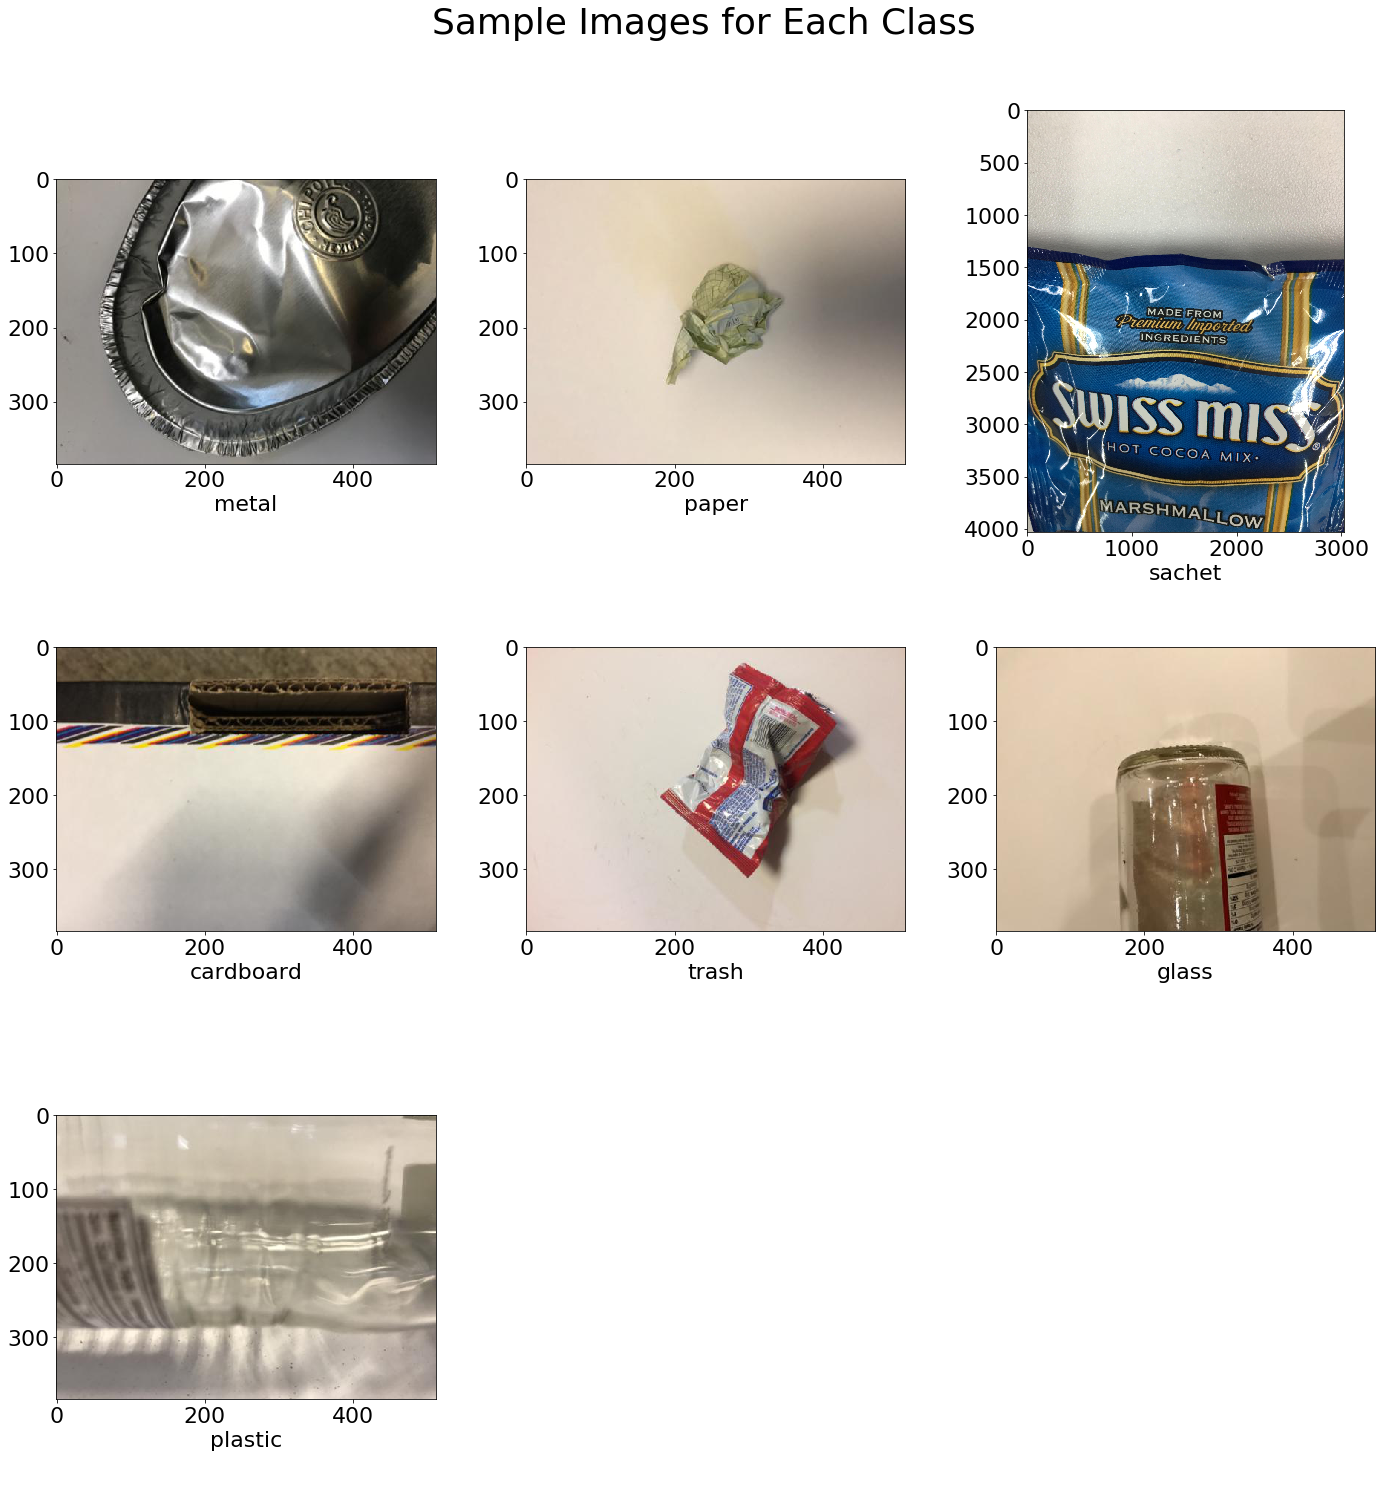

In [49]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

fig.suptitle('Sample Images for Each Class', fontsize=36, y=1.05)
plt.rcParams.update({'font.size': 22})

for i in range(7):
    img = load_img(sample_image_dir[i])
    img = img_to_array(img, dtype=np.uint8)
    
    ax[i//3][i%3].imshow(img)
    ax[i//3][i%3].set_xlabel(garbages[i])
    
ax[2, 1].axis('off')
ax[2, 2].axis('off');

plt.tight_layout()

# Methodology


## ImageNet

Developed by Fei-Fei Li, the ImageNet project is a large visual database for use in visual object recognition software research. This database contains more than 14 million images with more than 20,000 categories and is widely used as a benchmark for image classification algorithms. In Figure 3, we see example images from the dataset.

<img src='imagenet.png'>

History has shown that convolutional neural networks (CNN) provide the best results when classifying images. In 2012, a CNN called AlexNet achieved a top-5 error of 15.3% in the ImageNet 2012 Challenge, which is more than 10.8% lower than the runner up. Since then, multiple CNNs have been used on this dataset, which includes Xception, VGG16, VGG19, ResNet, and InceptionV3. On November 11, 2019, Xie et al published the Noisy Student method, which is based on the EfficientNet model to achieve the state top-1 accuracy of 87.4%.

## Xception

In this paper, we use the Xception model as a base for our classifier. This is due to ease of access, with weights that are trained for ImageNet available in Keras and good performance, with a top-1 accuracy of 79% and top-5 accuracy of 94.5%. We now discuss the architecture of the Xception model.


### Modified Separable Convolution



The layers on the Xception model are similar to those found in other CNNs. These include multiple 2D convolution layers, together with max pooling. Where Xception differs is in the additional modified separable convolution. A visualization of the separable convolution may be seen in Figure 4.

<img src='separable_convolution.png'>

The modified separable convolution has two major operations, the pointwise convolution and the depthwise convolution. A pointwise convolution is just a $1 \times 1$ convolution with a channel for each filter in the previous layer. A depthwise convolution on the other hand separates each filter from the prevous layer and applies an $n \times n$ convolution separately. The original separable convolution first applies a depthwise convolution, before applying a pointwise convolution. Xception on the other hand modifies this operation by first applying pointwise convolution before the depthwise convolution.



### Xception Model

The layers used for the Xception model may be seen in Figure 5. In our application, we use the weights trained on the ImageNet dataset except for the optional fully connected layers and the output layer. This provides us with 20M trained parameters. We train our own fully connected layer with 256 units and a Dropout layer with a rate of 0.5. Instead of a dense output layer with a logistic regression activation function, we use softmax instead. This provides us with a total of 100M trainable parameters.

<img src='xception.png'>

In [58]:
conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(512, 384, 3))
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 191, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 191, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 191, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Feed Forward (Convolutional Base)

We now takes images from the dataset and feeds it forward to the pretrained Xception base. Sachet images have a different image size so it is resized to 512 by 384 pixels to make it uniform to the other classes. To keep within memory limits, we only take 1000 out of 2630 data points.

In [3]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

directory = 'garbage classification/Garbage classification/'
sample_count = 1000
features = np.zeros(shape=(sample_count, 16, 12, 2048))
labels = np.zeros(shape=(sample_count))
generator = datagen.flow_from_directory(
    directory,
    target_size=(512, 384),
    batch_size=batch_size,
    class_mode='binary')
i = 0
for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
        break


Found 2630 images belonging to 7 classes.


In [4]:
generator.class_indices

{'cardboard': 0,
 'glass': 1,
 'metal': 2,
 'paper': 3,
 'plastic': 4,
 'sachet': 5,
 'trash': 6}

In [60]:
features.shape

(1000, 16, 12, 2048)

In [61]:
labels.shape

(1000,)

In the sample that we use, we see that cardboard, glass, metal, paper and plastic are more common types of trash with 150-200 images, while sachets and trash are less common with around 50 images.

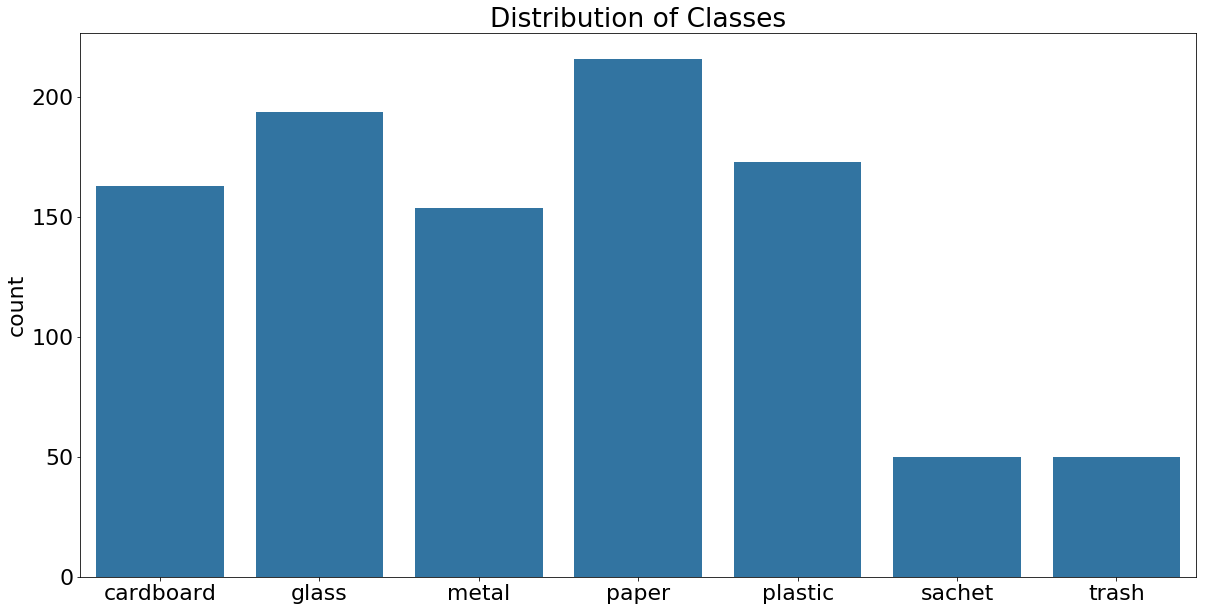

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.rcParams.update({'font.size': 22})

sns.countplot(labels, color='C0', ax=ax)
ax.set_title('Distribution of Classes')
ax.set_xticklabels(list(generator.class_indices.keys()), fontsize=22);

We compute for the PCC for our baseline. From the cell below, we obtain $PCC = 0.1695$ so the accuracy to beat is $1.25PCC = 0.2119.$

In [6]:
class_counts = Counter(labels)

pcc = 0.

for clas in class_counts:
    pcc += (class_counts[clas]/1000)**2
    
print('PCC:', pcc)
print('1.25PCC:', 1.25*pcc)

PCC: 0.169506
1.25PCC: 0.21188249999999997


We split our data into train, validation and test splits by taking the first 600 as train, next 200 as validation then last 200 as test test. Upon inspecting, we see in the graphs below that the distribution of the classes in each split is close to the original distribution.

In [7]:
X_train = features[:600, :, :, :]
y_train = to_categorical(labels[:600])
X_train.shape

(600, 16, 12, 2048)

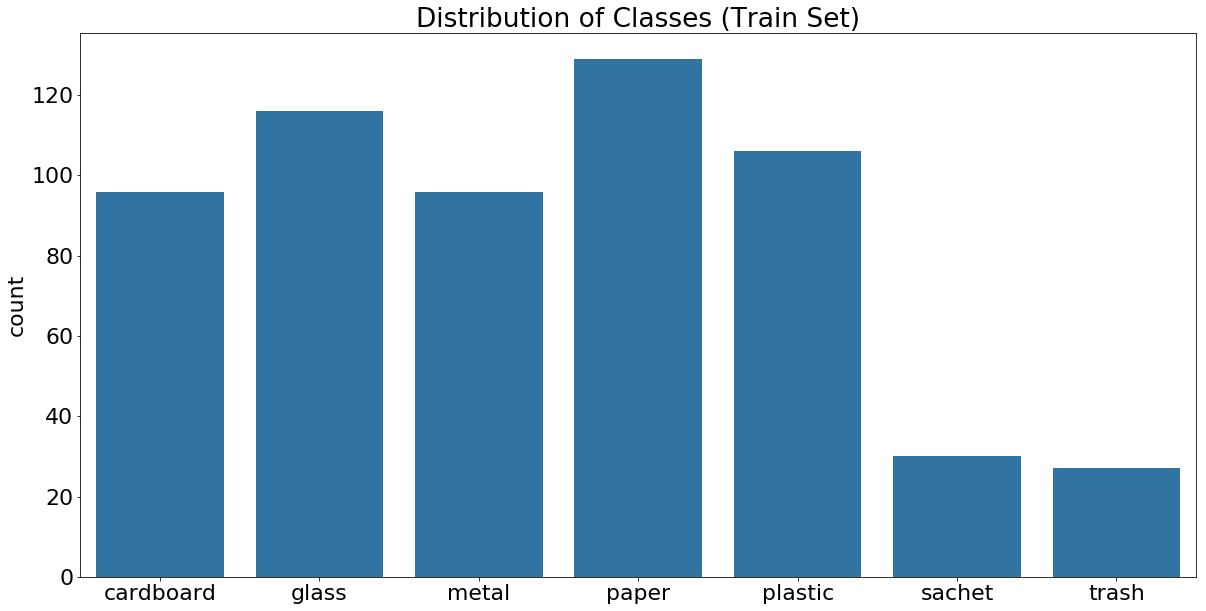

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.rcParams.update({'font.size': 22})

sns.countplot(labels[:600], color='C0', ax=ax)
ax.set_title('Distribution of Classes (Train Set)')
ax.set_xticklabels(list(generator.class_indices.keys()), fontsize=22);

In [8]:
X_val = features[600:800, :, :, :]
y_val = to_categorical(labels[600:800])
X_val.shape

(200, 16, 12, 2048)

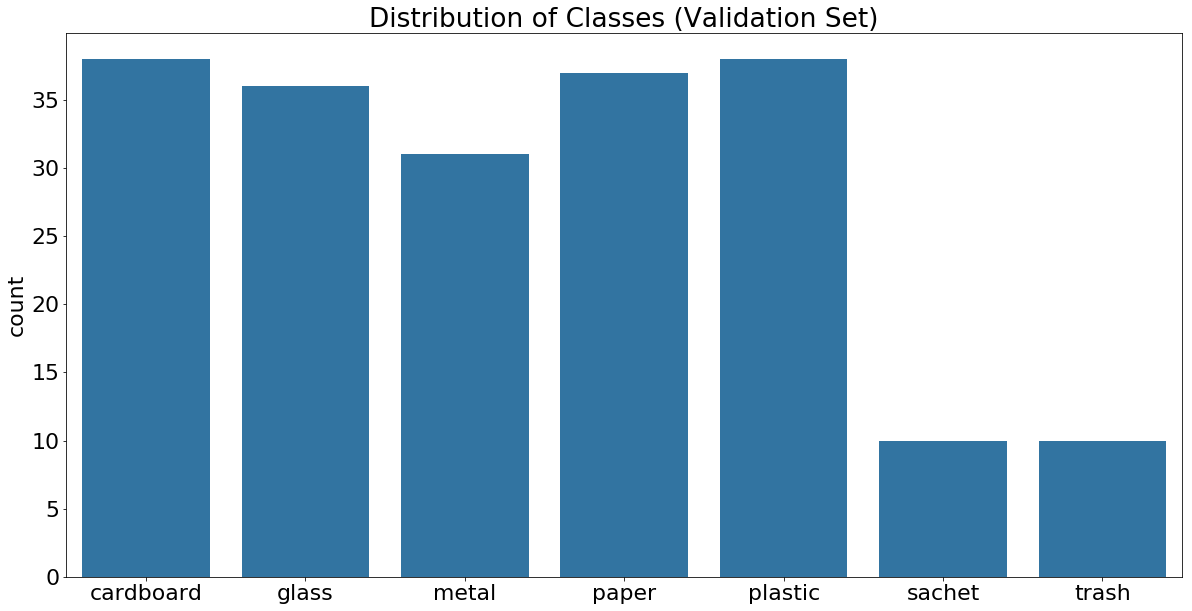

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.rcParams.update({'font.size': 22})

sns.countplot(labels[600:800], color='C0', ax=ax)
ax.set_title('Distribution of Classes (Validation Set)')
ax.set_xticklabels(list(generator.class_indices.keys()), fontsize=22);

In [9]:
X_test = features[800:, :, :, :]
y_test = to_categorical(labels[800:])
X_test.shape

(200, 16, 12, 2048)

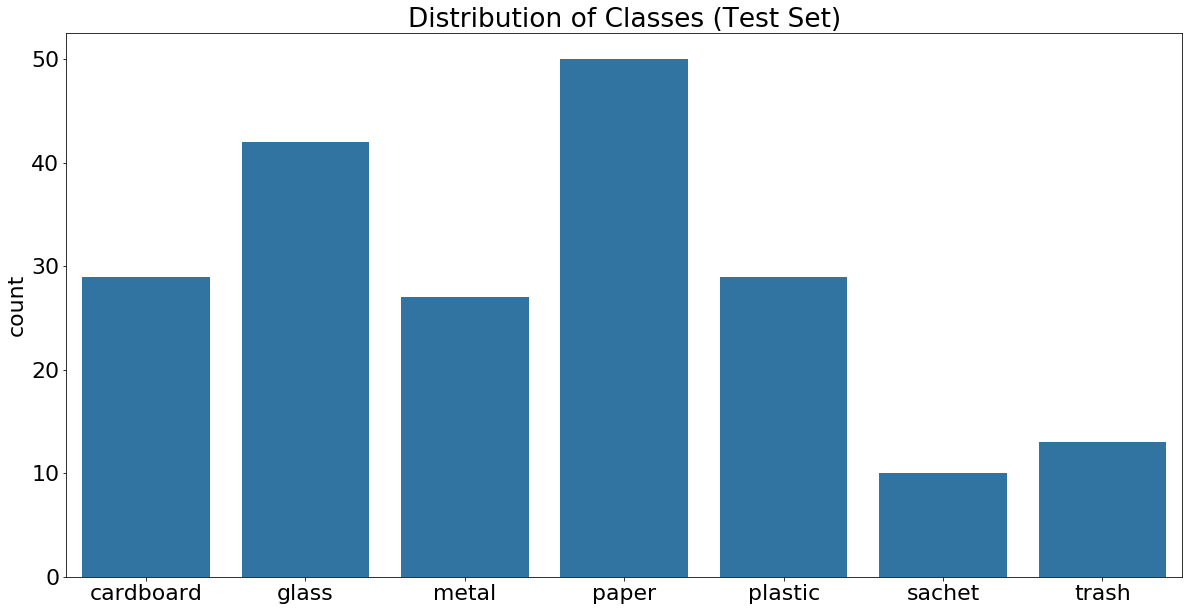

In [40]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.rcParams.update({'font.size': 22})

sns.countplot(labels[800:], color='C0', ax=ax)
ax.set_title('Distribution of Classes (Test Set)')
ax.set_xticklabels(list(generator.class_indices.keys()), fontsize=22);

We flatten our features so that we can input it in the fully connected layers.

In [10]:
X_train = np.reshape(X_train, (600, 16*12*2048))
X_val = np.reshape(X_val, (200, 16*12*2048))
X_test = np.reshape(X_test, (200, 16*12*2048))

## Fully Connected Layers



As discussed earlier, after the feed-forward process on the convolutional base, we pass the results through a fully connected layer with 256 units and add a dropout layer with a rate of 0.2. We then use a fully connected network as an output layer with 7 units, one for each class. All in all, we have 100M parameters. The activation function for the first dense layer is relu, while the activation function for the output layer is softmax.
	We compile the model using the Adam optimizer and categorical cross-entropy function. We also save the model with the best validation accuracy for use in the test dataset. The summary of the model may be seen in Figure 6.

In [25]:
model7 = models.Sequential()
model7.add(layers.Dense(256, activation='relu', input_dim=393216))
model7.add(layers.Dropout(0.2))
model7.add(layers.Dense(7, activation='softmax'))

filepath="trained_model_new_7.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model7.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               100663552 
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 1799      
Total params: 100,665,351
Trainable params: 100,665,351
Non-trainable params: 0
_________________________________________________________________


# Results



After fitting the model for 30 epochs with batch size 20, we obtained the best train accuracy of 0.9948 and a validation accuracy of 0.82. From the figure below, we see that there are no substantial improvements on the performance of the model after 10 epochs.

In [26]:
history_xception_7 = model7.fit(X_train, y_train,
                   epochs=30,
                   batch_size=20,
                   validation_data=(X_val, y_val),
                   callbacks=callbacks_list)

Train on 600 samples, validate on 200 samples
Epoch 1/30
580/600 [============================>.] - ETA: 2s - loss: 17.9358 - acc: 0.5466
Epoch 00001: val_acc improved from -inf to 0.71000, saving model to trained_model_new_7.h5
600/600 [==============================] - 145s 242ms/sample - loss: 17.6099 - acc: 0.5500 - val_loss: 7.2980 - val_acc: 0.7100
Epoch 2/30
580/600 [============================>.] - ETA: 0s - loss: 1.8881 - acc: 0.8707
Epoch 00002: val_acc improved from 0.71000 to 0.73500, saving model to trained_model_new_7.h5
600/600 [==============================] - 91s 151ms/sample - loss: 1.8715 - acc: 0.8717 - val_loss: 5.1422 - val_acc: 0.7350
Epoch 3/30
580/600 [============================>.] - ETA: 0s - loss: 0.5274 - acc: 0.9345
Epoch 00003: val_acc improved from 0.73500 to 0.78500, saving model to trained_model_new_7.h5
600/600 [==============================] - 92s 153ms/sample - loss: 0.5198 - acc: 0.9333 - val_loss: 3.8706 - val_acc: 0.7850
Epoch 4/30
580/600 [=

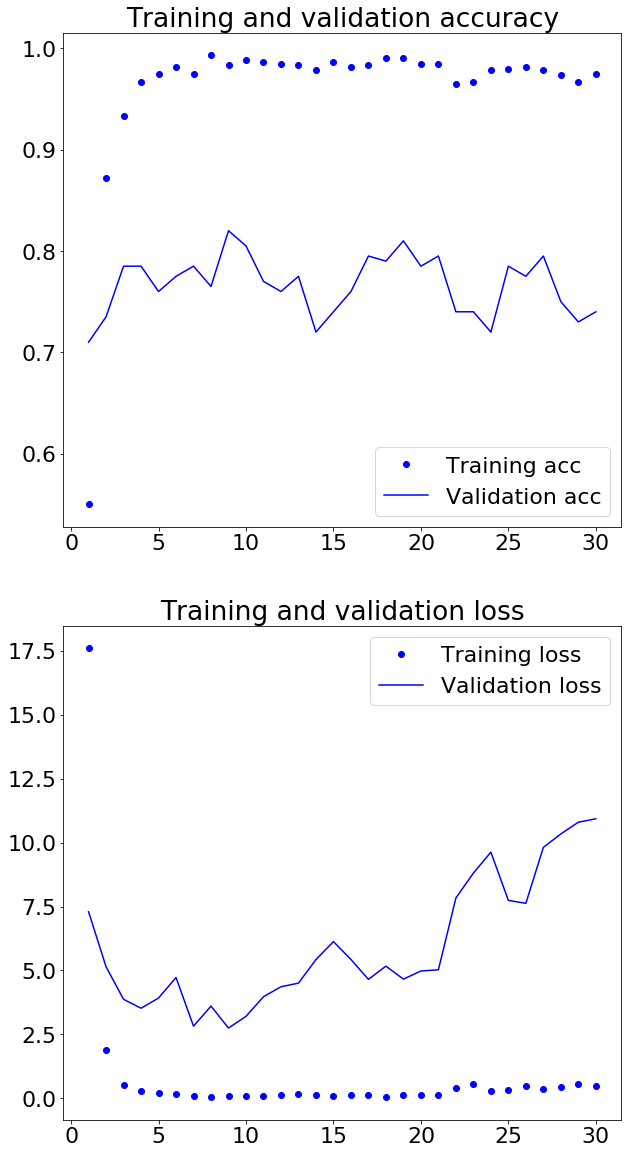

In [28]:
acc = history_xception_7.history['acc']
val_acc = history_xception_7.history['val_acc']
loss = history_xception_7.history['loss']
val_loss = history_xception_7.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(2, 1, figsize=(10, 20))
ax[0].plot(epochs, acc, 'bo', label='Training acc')
ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

# plt.figure()

ax[1].plot(epochs, loss, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

# plt.show()

We now load the model with the best validation score. After predicting for the test set, we obtain $0.83$ accuracy, which is similar to the validation accuracy. The accuracy we obtained is much greater than $1.25PCC = 0.2119$ so the performance of this model is very good.

In [31]:
best_model = load_model("trained_model_new_7.h5")

In [32]:
y_pred = best_model.predict(X_test)
predictions = np.argmax(y_pred, axis=1)
actuals = np.argmax(y_test, axis=1)

In [33]:
(predictions == actuals).mean()

0.83

# Analysis



To have deeper insight on the model, we plot its confusion matrix. Here, we see that the model best classifies paper, cardboard, sachets and glass. On the other hand, it often misclassifies metal and plastic as glass, while trash are misclassified as metal or paper.

In [42]:
cm = confusion_matrix(actuals, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

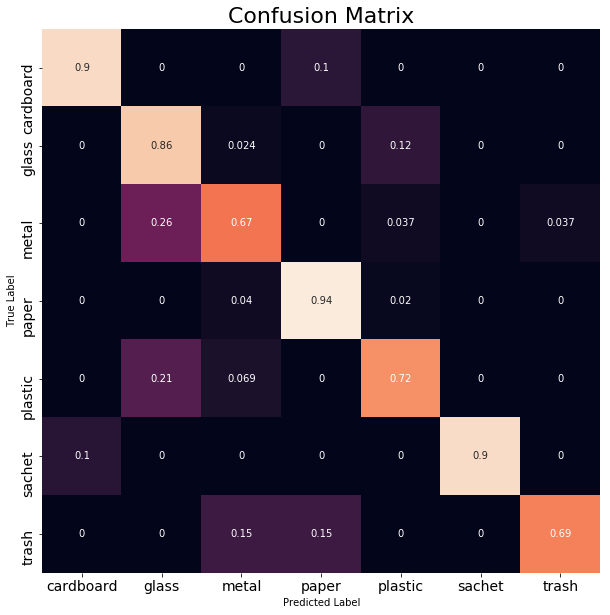

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(cm_normalized, annot=True, cbar=False)

ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix', fontsize=22)

class_names = list(generator.class_indices)

ax.set_xticklabels(class_names, fontsize=14)
ax.set_yticklabels(class_names, fontsize=14);

To have a better understanding on the performance of the model, we look at some examples of misclassifications. In the image below, we have a prediction of glass when the actual class is plastic. We see that the problem of classifying both cases is that the images involve a large transparent area with possible label stickers. We may improve the performance of the model by adding more examples and augmenting the images, but currently are not able to do so due to hardware limitations. This process may capture the subtle differences between the two classes.

Predicted glass
Actual plastic


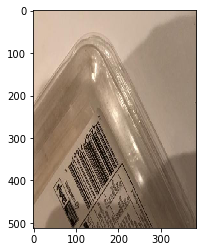

In [87]:
print('Predicted', class_names[predictions[-20+3]])
print('Actual', class_names[actuals[-20+3]])
plt.imshow(inputs_batch[3,:,:,:])
plt.show()

In the second case, we classified trash as paper. By looking at other examples of trash, this class is the hardest to classify since it includes a diverse type of images. This include nonrecyclable products like apple core. Here, we also believe that there are still potential gains to be had with more images and augmentations.

Predicted paper
Actual trash


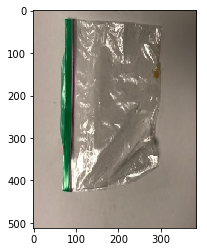

In [88]:
print('Predicted', class_names[predictions[-20+13]])
print('Actual', class_names[actuals[-20+13]])
plt.imshow(inputs_batch[13,:,:,:])
plt.show()

# Conclusions and Recommendations

This paper presented a framework for garbage classification using convolutional neural networks. We used transfer learning using the Xception model by Google that was pre-trained on the ImageNet dataset. We were able to consider the Philippine context by augmenting the original dataset with sachets which is a product of our “sachet culture.” Our model was able to classify garbage in seven classes, namely, metal, paper, cardboard, trash, glass, plastic, and sachet. The model was able to classify garbage images at an 83% accuracy beating the 1.25*PCC and Kaggle baseline. 

The model developed in this research generalizes garbage in only limited to seven classes. The model can be further improved by adding classes that require a separate waste processing purpose.  Currently, the model is only able to classify one class of garbage in an image at a time. To adapt to real-world applications where garbage is bunched together, the model should be scaled up to an object detection model where it can classify multiple objects in an image using bounding boxes. This will enable the model to process satellite or drone images.
    
This research can be used as a reference when planning the Philippine AI roadmap. It can help augment and automate waste segregation facilities using IoT powered robots and increase throughput. Automation can increase the morale of our fellow Filipino people since we can now leave waste segregation jobs to AI so that we can upskill our workforce.

This research can help in educating both the youth and adults on waste segregation through a mobile application with a built-in garbage classifier. This will help address the remaining gap in the understanding of waste segregation. The app will just be a simple point and shoot camera that outputs details on the recycling and disposal of any garbage.  

This research can help in policymaking for monitoring the footprint of FMCG companies. A similar model can be developed using convolutional neural networks to classify what the company manufactured certain garbage. In the case of sachets, a model can be developed to detect the brand name in the sachets. This can help our government to quantify and attribute waste to companies. This can help in creating policies focused on penalizing and managing companies to decrease their waste footprint.



# Acknowledgements


We would like to acknowledge our professors for the course Machine Learning 2.0 at the Asian Institute of Management Dr. Christopher Monterola, Dr. Erika Legara, Dr. Christian Alis, and Prof. Eduardo David. We would also like to thank Amazon Web Services and Acer for providing us with the computing resources for this project.

# References



1. Chollet, F. (2017). Xception: Deep Learning with Depthwise Separable Convolutions. CVPR. doi:10.1109/CVPR.2017.195
2. Tsang, S. (2018). Review: Xception — With Depthwise Separable Convolution, Better Than Inception-v3 (Image Classification). Retrieved from https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568 on December 22, 2019.
3. Garbage Classification Dataset. Retrieved from https://www.kaggle.com/asdasdasasdas/garbage-classification on December 11, 2019.